In [1]:

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    recall_score, f1_score, matthews_corrcoef, precision_recall_curve,
    roc_auc_score, auc
)

# Statistical tests
from scipy.stats import chi2_contingency

In [2]:
# Read in the dataset

df = pd.read_csv('diabetes_dataset.csv')
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

Examining the data:
- 100,000 entries, 15 columns including target
- 3 categorical columns - 'gender', 'location', 'smoking-history'
- no na values
- our target variable 'diabetes' is already an int: 0 = does not have diabetes, 1 = does


In [4]:
df.columns

Index(['year', 'gender', 'age', 'location', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'hbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

# Score a baseline Logistic Regression and Random Forest model 

In [5]:
# Establish Scoring df

scoring_df = pd.DataFrame()

In [6]:
# Evaluate baseline LogisticRegression model with full featureset

# Create a `LogisticRegression` function
lr_model = LogisticRegression()

# Get our target feature, drop uninformative

X = df.drop(columns=['diabetes','location', 'year'], axis=1)
y = df['diabetes']

# Split the data into training and testing sets before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

# Perform one-hot encoding 
ohe = OneHotEncoder(drop='first', dtype='int', sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Fit the model on the encoded training data
lr_model.fit(X_train_encoded, y_train)

# Make predictions on both train and test data
train_predictions = lr_model.predict(X_train_encoded)
test_predictions = lr_model.predict(X_test_encoded)
test_probabilities = lr_model.predict_proba(X_test_encoded)[:, 1]

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({"Predictions": test_predictions, "Actual": y_test})

# Calculate the model's accuracy on both train and test datasets
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)  
f1 = f1_score(y_test, test_predictions)
mcc = matthews_corrcoef(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Create a dictionary with the model name and scores
model_scores = {
    'Model': ['Log Reg'],
    'Train Accuracy': [train_accuracy],
    'Test Accuracy': [test_accuracy],
    'Recall': [recall],
    'F1 Score': [f1],
    'MCC': [mcc],
    'ROC-AUC': [roc_auc]
}

# Convert the dictionary to a DataFrame
model_df = pd.DataFrame(model_scores)

# Concatenate this DataFrame with your existing scoring_df
scoring_df = pd.concat([scoring_df, model_df], ignore_index=True)

# Display the updated scoring DataFrame
display(scoring_df)



c:\Users\16148\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,Train Accuracy,Test Accuracy,Recall,F1 Score,MCC,ROC-AUC
0,Log Reg,0.972533,0.97216,0.688366,0.810767,0.81126,0.975901


In [7]:
# Compare to baseline RandomForest Model

ohe = OneHotEncoder(drop='first', dtype='int')
model = RandomForestClassifier(random_state=42)

# Drop columns that won't be useful
# year - year the data was collected
# location
# Drop columns that won't be useful
dropped_df = df.drop(columns=['location', 'year'])

# Get our target feature
X = dropped_df.drop(columns='diabetes')
y = df['diabetes']

# Split into our test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

# Define the columns to encode
columns_to_encode = ['gender', 'smoking_history']

# Create the ColumnTransformer
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore'), columns_to_encode)
], remainder='passthrough')

# Fit on the training data and transform both training and test data
X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

# Create and fit our model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded, y_train)

# Make predictions on both train and test data
train_predictions = model.predict(X_train_encoded)
test_predictions = model.predict(X_test_encoded)

# For ROC-AUC, we need probability predictions
train_prob_predictions = model.predict_proba(X_train_encoded)[:, 1]
test_prob_predictions = model.predict_proba(X_test_encoded)[:, 1]

# Calculate the metrics for Random Forest
rf_train_accuracy = accuracy_score(y_train, train_predictions)
rf_test_accuracy = accuracy_score(y_test, test_predictions)
rf_recall = recall_score(y_test, test_predictions)
rf_f1 = f1_score(y_test, test_predictions)
rf_mcc = matthews_corrcoef(y_test, test_predictions)
rf_roc_auc = roc_auc_score(y_test, test_prob_predictions)

# Create a dictionary with the Random Forest model name and scores
rf_model_scores = {
    'Model': ['Random Forest'],
    'Train Accuracy': [rf_train_accuracy],
    'Test Accuracy': [rf_test_accuracy],
    'Recall': [rf_recall],
    'F1 Score': [rf_f1],
    'MCC': [rf_mcc],
    'ROC-AUC': [rf_roc_auc]
}

# Convert the dictionary to a DataFrame
rf_model_df = pd.DataFrame(rf_model_scores)

# Concatenate this DataFrame with your existing scoring_df
scoring_df = pd.concat([scoring_df, rf_model_df], ignore_index=True)

# Display the updated scoring DataFrame
print("\nUpdated Scoring DataFrame:")
display(scoring_df)



Updated Scoring DataFrame:


,Model,Train Accuracy,Test Accuracy,Recall,F1 Score,MCC,ROC-AUC
0,Log Reg,0.972533,0.97216,0.688366,0.810767,0.811260,0.975901
1,Random Forest,0.999853,0.96872,0.663582,0.785753,0.785052,0.957101


# Begin Exploratory Data Analysis

In [8]:
# Rename columns for clarity

print(df.columns)


new_names = {
    'year': 'Year',
    'gender': 'Gender',
    'age' : 'Age',
    'location' :'Location',
    'race:AfricanAmerican' : "Race : African American",
    'race:Asian' : 'Race : Asian',
    'race:Caucasian' : 'Race : Caucasian',
    'race:Hispanic' : 'Race : Hispanic',
    'race:Other' : 'Race : Other',
    'hypertension' : 'Hypertension',
    'heart_disease' : 'Heart Disease',
    'smoking_history' : 'Smoking History',
    'bmi' : 'BMI',
    'hbA1c_level' : 'HbA1c Level',
    'blood_glucose_level' : 'Blood Glucose Level',
    'diabetes' : 'Diabetes'
}
df = df.rename(columns=new_names)

df.columns

Index(['year', 'gender', 'age', 'location', 'race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'hbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes'],
      dtype='object')

In [9]:
# Checking for class imbalance for target 

df['Diabetes'].value_counts(normalize=True)

Diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

Noticing a major imbalance, we will need to apply a technique to address this. SMOTE?

In [10]:
# Examine catgoric columns

print(df['Smoking History'].value_counts())

print(df['Gender'].value_counts(normalize=True))

df['Gender'].value_counts()


Smoking History
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
Gender
Female    0.58552
Male      0.41430
Other     0.00018
Name: proportion, dtype: float64


Gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

Smoking History: 
- has a "No Info" category
- whats the difference between former and not current?
- what is 'ever'?
- maybe combine some of the categories
- consider different encoding strategies
Gender:
- dataset contains more females than males
- gender has an 'Other' category with only 18 entries 

In [11]:
# Examine the "Other" gender category
other_df = df[df['Gender'] == 'Other']
other_df

,Year,Gender,Age,Location,Race : African American,Race : Asian,Race : Caucasian,Race : Hispanic,Race : Other,Hypertension,Heart Disease,Smoking History,BMI,HbA1c Level,Blood Glucose Level,Diabetes
1611,2019,Other,23.0,Alabama,0,1,0,0,0,0,0,No Info,24.23,6.1,140,0
2550,2019,Other,19.0,Alaska,0,0,1,0,0,0,0,No Info,27.32,5.7,158,0
2787,2019,Other,39.0,Alaska,0,1,0,0,0,0,0,not current,31.24,6.2,85,0
4385,2015,Other,10.0,Arizona,1,0,0,0,0,0,0,not current,14.09,5.0,140,0
5064,2019,Other,10.0,Arizona,0,0,1,0,0,0,0,not current,16.59,6.1,160,0
7975,2019,Other,45.0,Arkansas,0,0,0,1,0,0,0,never,27.32,4.0,159,0
19647,2019,Other,47.0,Florida,0,0,1,0,0,0,0,never,36.76,6.6,90,0
19658,2019,Other,47.0,Florida,1,0,0,0,0,0,0,never,36.76,3.5,200,0
22784,2019,Other,53.0,Guam,0,0,1,0,0,0,0,No Info,27.32,6.6,160,0
32002,2019,Other,18.0,Iowa,0,0,1,0,0,0,0,not current,30.19,6.1,90,0


In [12]:
# Examine numeric columns
print(df.select_dtypes(include=['int64', 'float64']).columns)

Index(['Year', 'Age', 'Race : African American', 'Race : Asian',
       'Race : Caucasian', 'Race : Hispanic', 'Race : Other', 'Hypertension',
       'Heart Disease', 'BMI', 'HbA1c Level', 'Blood Glucose Level',
       'Diabetes'],
      dtype='object')


- the 'Race' categories are already 'encoded' although there are only 5 categories

In [13]:
# Examine the either/or columns

print(df['Hypertension'].value_counts(normalize=True))

print(df['Heart Disease'].value_counts(normalize=True))

Hypertension
0    0.92515
1    0.07485
Name: proportion, dtype: float64
Heart Disease
0    0.96058
1    0.03942
Name: proportion, dtype: float64


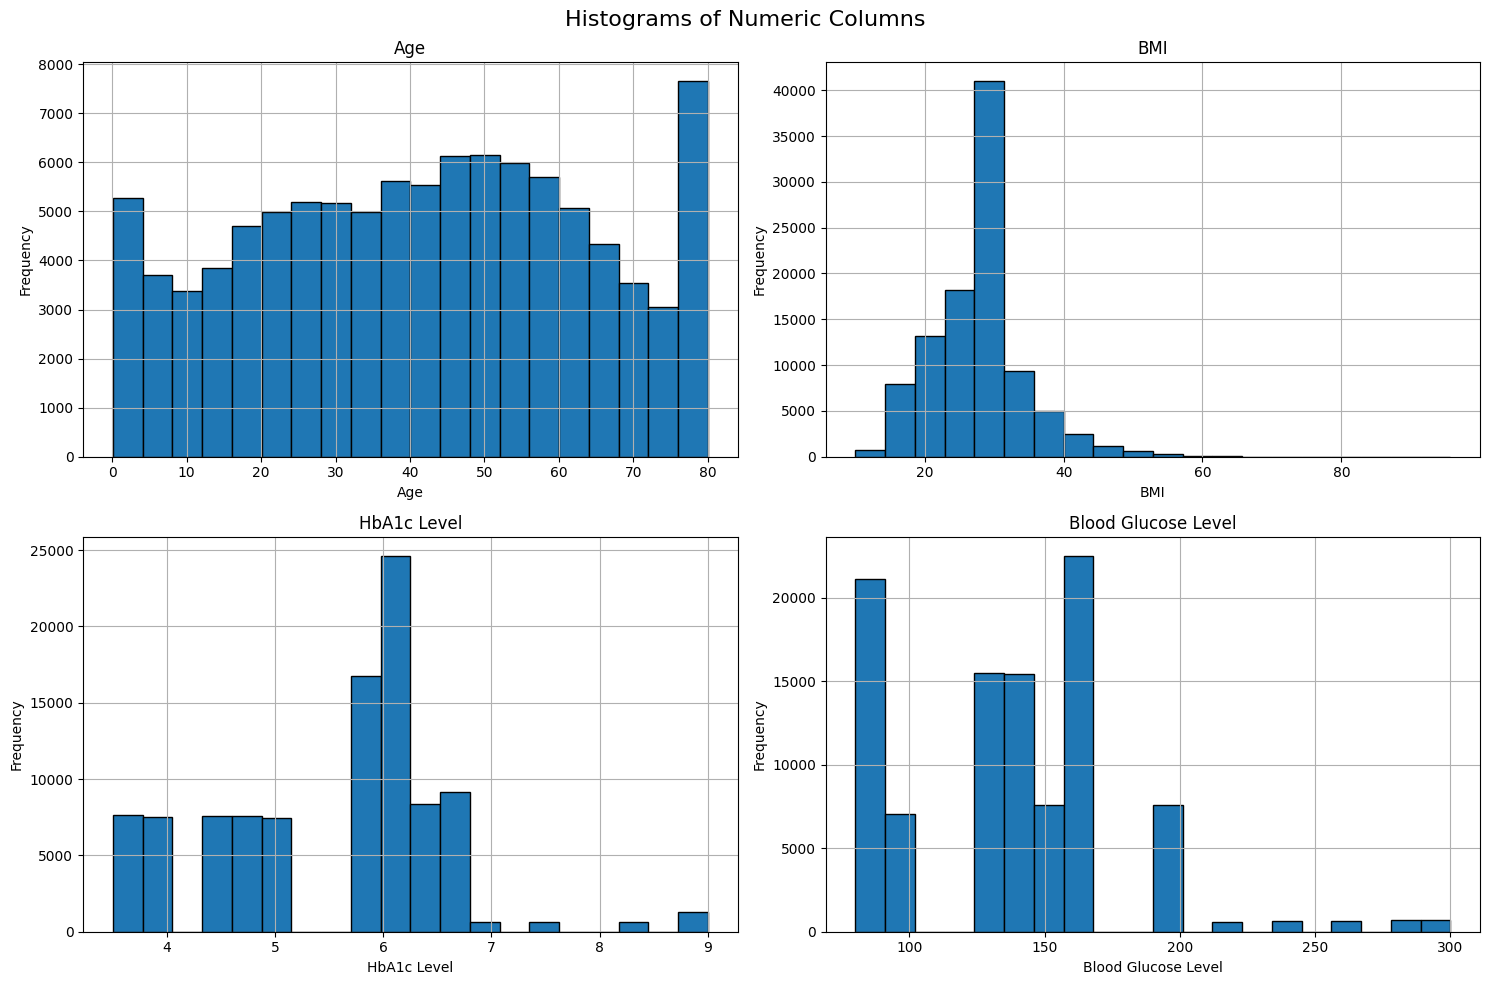

In [14]:
# Visualize other numeric columns

# List of columns to visualize
columns_to_visualize = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Histograms of Numeric Columns', fontsize=16)

axes = axes.flatten()

# Create histograms for each specified column
for i, column in enumerate(columns_to_visualize):
    df[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Age:
- Age is capped at 80. anything over 80 is just 80
BMI:
 skewed, long tail. investigate outliers, maybe log transform, scale, or binning also
HbA1c:
investigate outliers, bin based on clinical categories?
blood glucose:
 clinical categories/thresholds?

In [15]:
df['Age'].value_counts()

Age
80.00    5621
51.00    1619
47.00    1574
48.00    1568
53.00    1542
         ... 
0.48       83
1.00       83
0.40       66
0.16       59
0.08       36
Name: count, Length: 102, dtype: int64

In [16]:
df['HbA1c Level'].value_counts()

HbA1c Level
6.6    8540
5.7    8413
6.5    8362
5.8    8321
6.0    8295
6.2    8269
6.1    8048
3.5    7662
4.8    7597
4.5    7585
4.0    7542
5.0    7471
8.8     661
8.2     661
9.0     654
7.5     643
6.8     642
7.0     634
Name: count, dtype: int64

In [17]:
df['Blood Glucose Level'].value_counts()

Blood Glucose Level
130    7794
159    7759
140    7732
160    7712
126    7702
145    7679
200    7600
155    7575
90     7112
80     7106
158    7026
100    7025
85     6901
280     729
300     674
240     636
260     635
220     603
Name: count, dtype: int64

In this dataset, 'HbA1c Level' and 'Blood Glucose Level' are NOT continuous.
There are 18 discrete values for each variable.

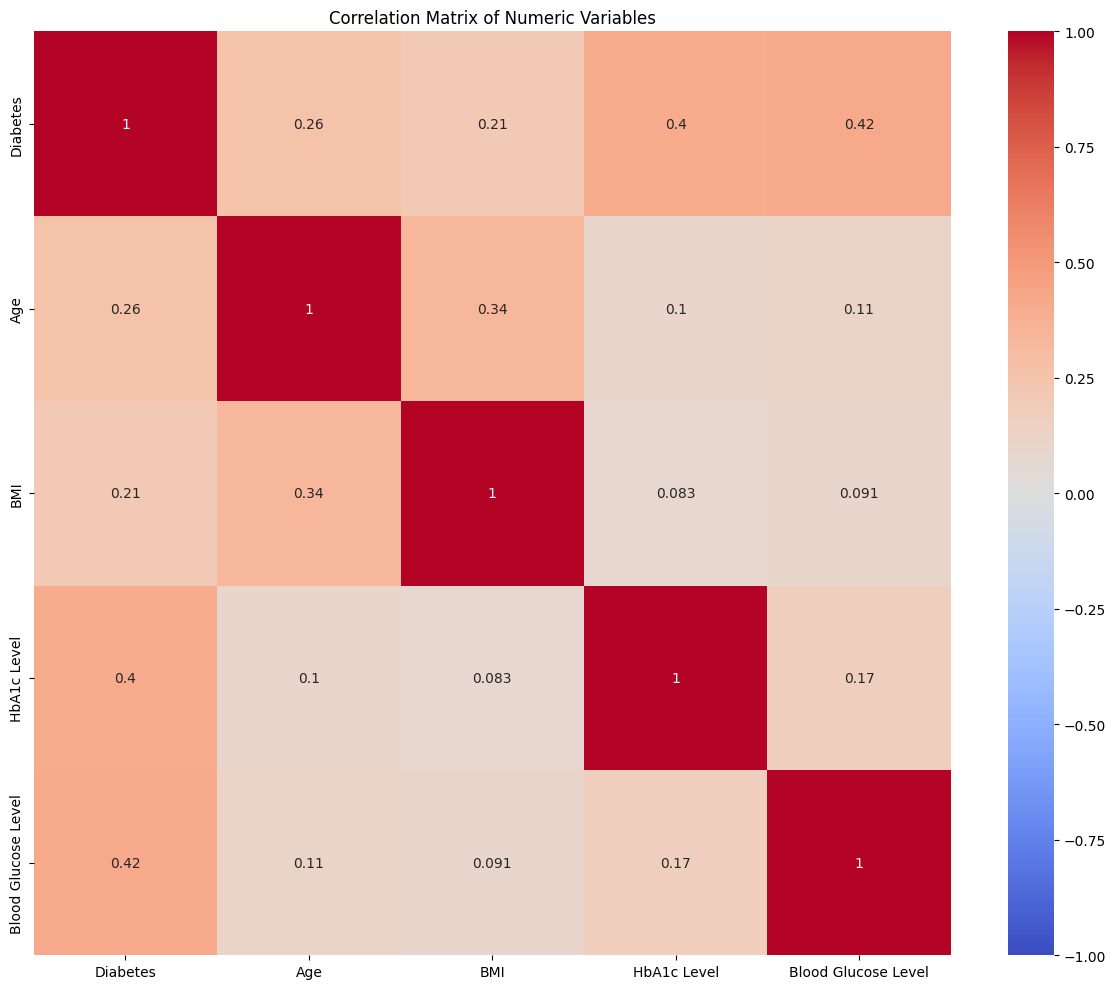

,Diabetes,Age,BMI,HbA1c Level,Blood Glucose Level
Diabetes,1.000000,0.258008,0.214357,0.400660,0.419558
Age,0.258008,1.000000,0.337396,0.101354,0.110672
BMI,0.214357,0.337396,1.000000,0.082997,0.091261
HbA1c Level,0.400660,0.101354,0.082997,1.000000,0.166733
Blood Glucose Level,0.419558,0.110672,0.091261,0.166733,1.000000


In [18]:
# Create a Correlation matrix to examine numeric columns relationship with target

# Select numeric columns
numeric_columns = ['Diabetes','Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
numeric_df = df[numeric_columns]

correlation_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmax=1, vmin=-1, center=0)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

correlation_matrix

Check the min/max values and other info with .describe()

In [19]:
df.describe()

,Year,Age,Race : African American,Race : Asian,Race : Caucasian,Race : Hispanic,Race : Other,Hypertension,Heart Disease,BMI,HbA1c Level,Blood Glucose Level,Diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [20]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes'],
      dtype='object')

In [21]:
# Checking for duplicates
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows

,Year,Gender,Age,Location,Race : African American,Race : Asian,Race : Caucasian,Race : Hispanic,Race : Other,Hypertension,Heart Disease,Smoking History,BMI,HbA1c Level,Blood Glucose Level,Diabetes
2782,2019,Male,40.0,Alaska,0,0,1,0,0,0,0,No Info,27.32,6.2,85,0
2848,2019,Male,40.0,Alaska,0,0,1,0,0,0,0,No Info,27.32,6.2,85,0
21379,2019,Male,65.0,Georgia,0,1,0,0,0,0,0,No Info,27.32,4.0,90,0
21662,2019,Male,65.0,Georgia,0,1,0,0,0,0,0,No Info,27.32,4.0,90,0
23282,2019,Female,21.0,Guam,0,1,0,0,0,0,0,never,27.32,6.6,155,0
23313,2019,Female,21.0,Guam,0,1,0,0,0,0,0,never,27.32,6.6,155,0
32127,2019,Male,13.0,Iowa,0,1,0,0,0,0,0,No Info,27.32,4.8,160,0
33506,2019,Male,13.0,Iowa,0,1,0,0,0,0,0,No Info,27.32,4.8,160,0
42946,2019,Male,46.0,Maryland,0,1,0,0,0,0,0,never,27.32,6.6,90,0
43401,2019,Male,46.0,Maryland,0,1,0,0,0,0,0,never,27.32,6.6,90,0


In [22]:
# Drop duplicates
print(f"Shape before dropping: {df.shape}")
print(f"Number of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(df.shape)

Shape before dropping: (100000, 16)
Number of duplicates: 14
(99986, 16)


## Visualizations


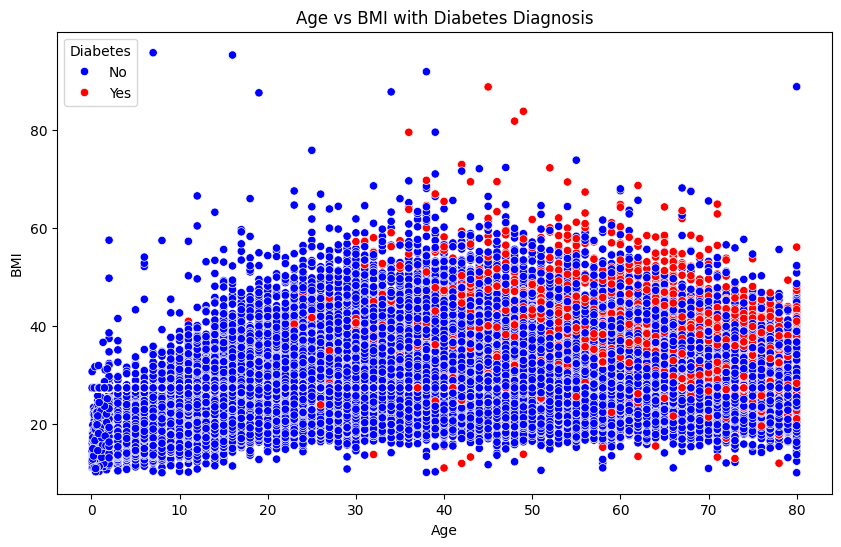

In [23]:
# Age vs BMI Scatterplot

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='Age', y='BMI', hue='Diabetes', palette={0: 'blue', 1: 'red'})
plt.title('Age vs BMI with Diabetes Diagnosis')
plt.xlabel('Age')
plt.ylabel('BMI')

# Create custom legend with correct colors
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=handles, title='Diabetes', labels=['No', 'Yes'])

plt.show()

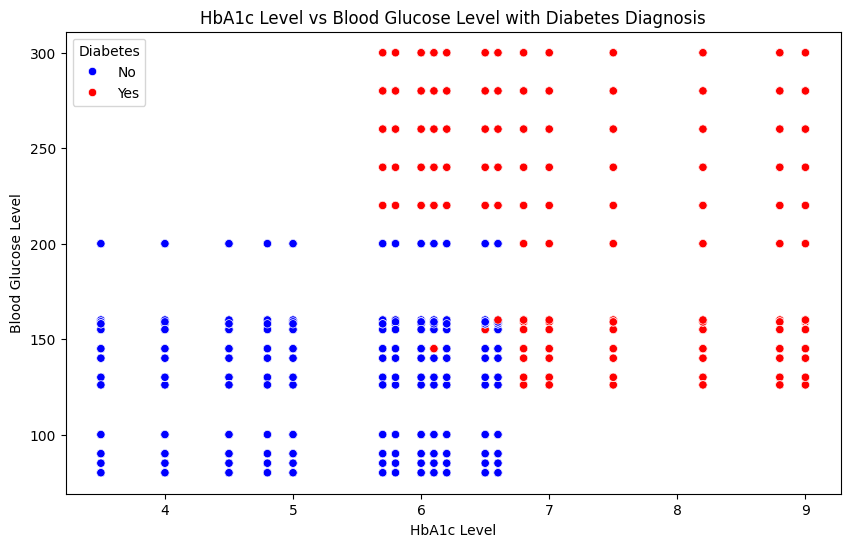

In [24]:
# Plot HbA1c Level vs Blood Glucose

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='HbA1c Level', y='Blood Glucose Level', hue='Diabetes', palette={0: 'blue', 1: 'red'})
plt.title('HbA1c Level vs Blood Glucose Level with Diabetes Diagnosis')
plt.xlabel('HbA1c Level')
plt.ylabel('Blood Glucose Level')

# Create custom legend with correct colors
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles=handles, title='Diabetes', labels=['No', 'Yes'])

plt.show()

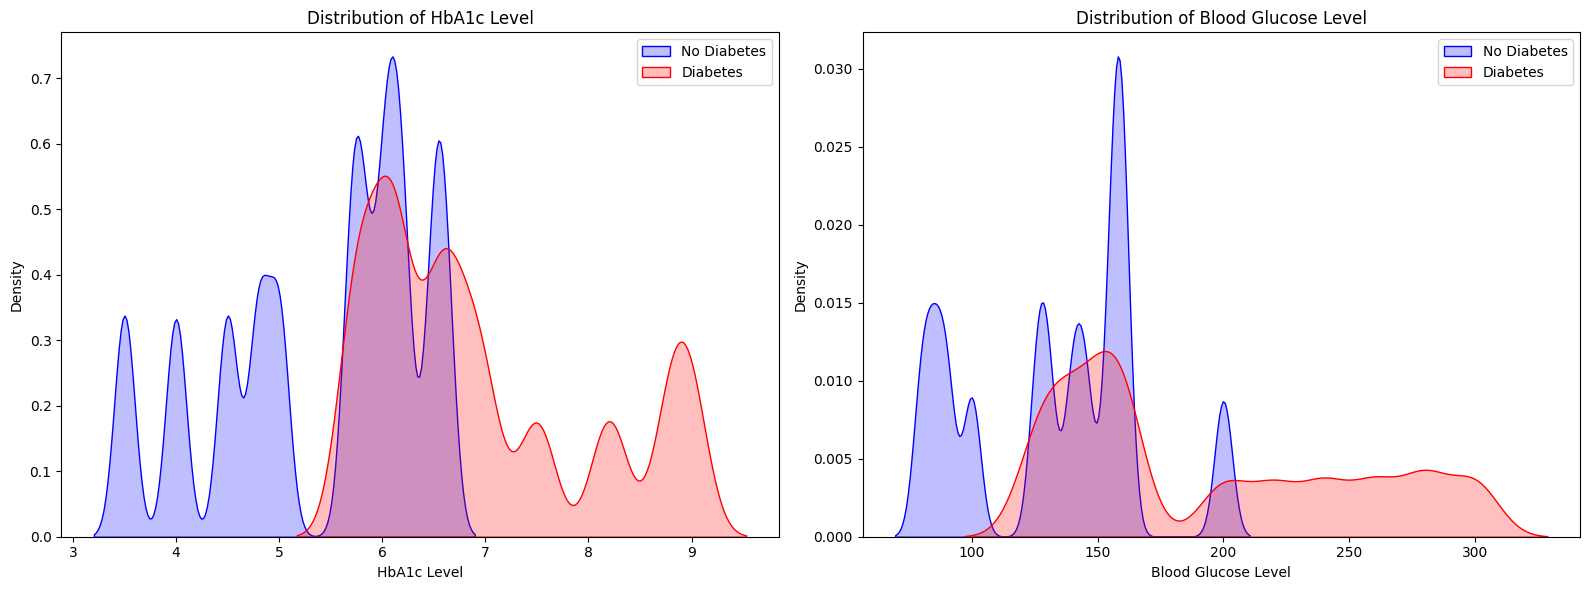

In [25]:
# KDE (Kernal Density Estimate) plots


plt.figure(figsize=(16, 6))

# HbA1c Level
plt.subplot(1, 2, 1)
sns.kdeplot(data=df[df['Diabetes'] == 0], x='HbA1c Level', fill=True, color='blue', label='No Diabetes')
sns.kdeplot(data=df[df['Diabetes'] == 1], x='HbA1c Level', fill=True, color='red', label='Diabetes')
plt.title('Distribution of HbA1c Level')
plt.xlabel('HbA1c Level')
plt.legend()

# Blood Glucose Level
plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df['Diabetes'] == 0], x='Blood Glucose Level', fill=True, color='blue', label='No Diabetes')
sns.kdeplot(data=df[df['Diabetes'] == 1], x='Blood Glucose Level', fill=True, color='red', label='Diabetes')
plt.title('Distribution of Blood Glucose Level')
plt.xlabel('Blood Glucose Level')
plt.legend()

plt.tight_layout()
plt.show()

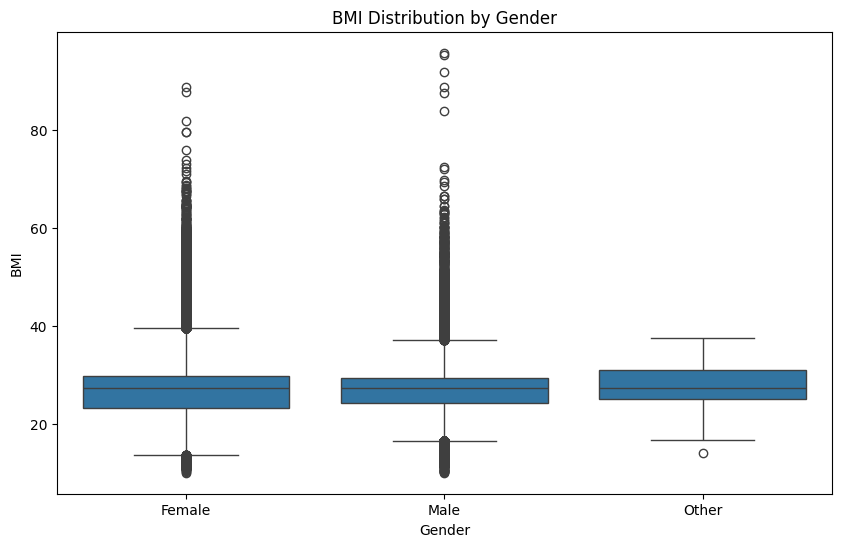

In [26]:
# BMI vs Gender

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gender', y='BMI')
plt.title('BMI Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.show()

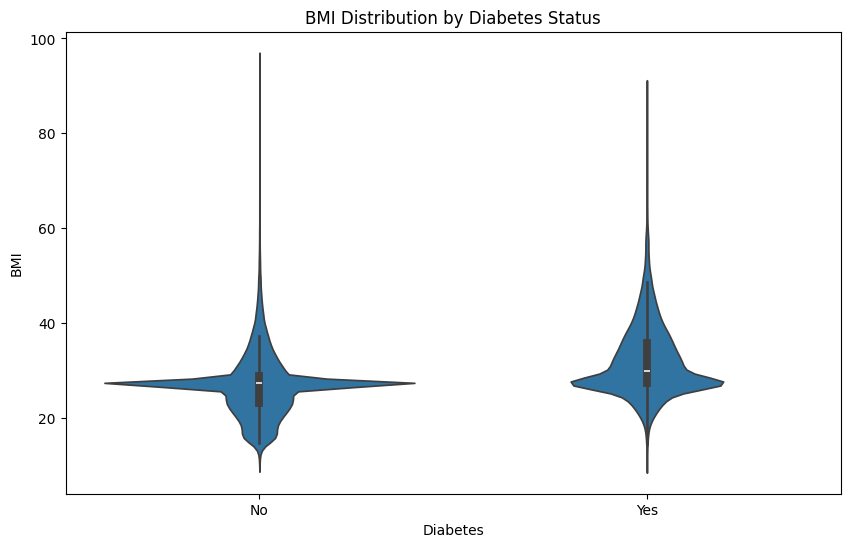

In [27]:
# Plot BMI vs Diabetes Status

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Diabetes', y='BMI')
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('Diabetes')
plt.ylabel('BMI')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

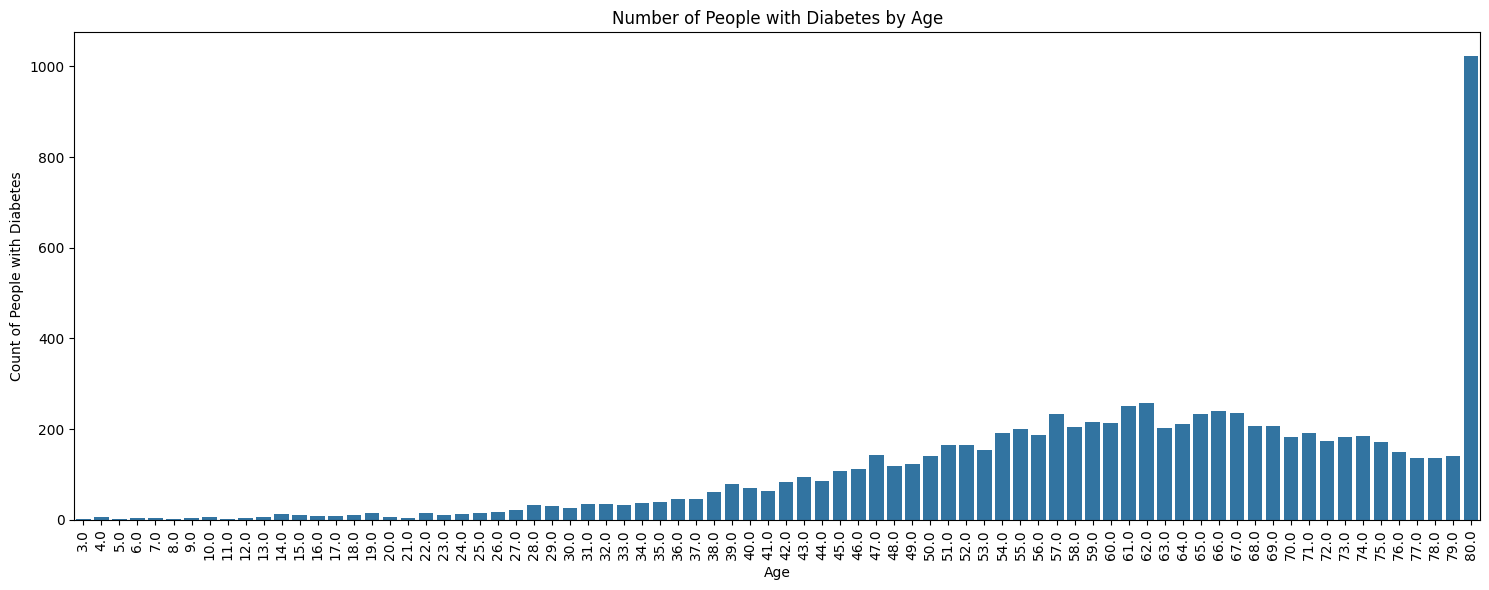

In [28]:
# Plot the Count of each Age with diabetes

# Calculate the count of people with diabetes for each age
diabetes_by_age = df[df['Diabetes'] == 1].groupby('Age').size().reset_index(name='Count')

# Create the plot
plt.figure(figsize=(15, 6))
sns.barplot(x='Age', y='Count', data=diabetes_by_age)

plt.title('Number of People with Diabetes by Age')
plt.xlabel('Age')
plt.ylabel('Count of People with Diabetes')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


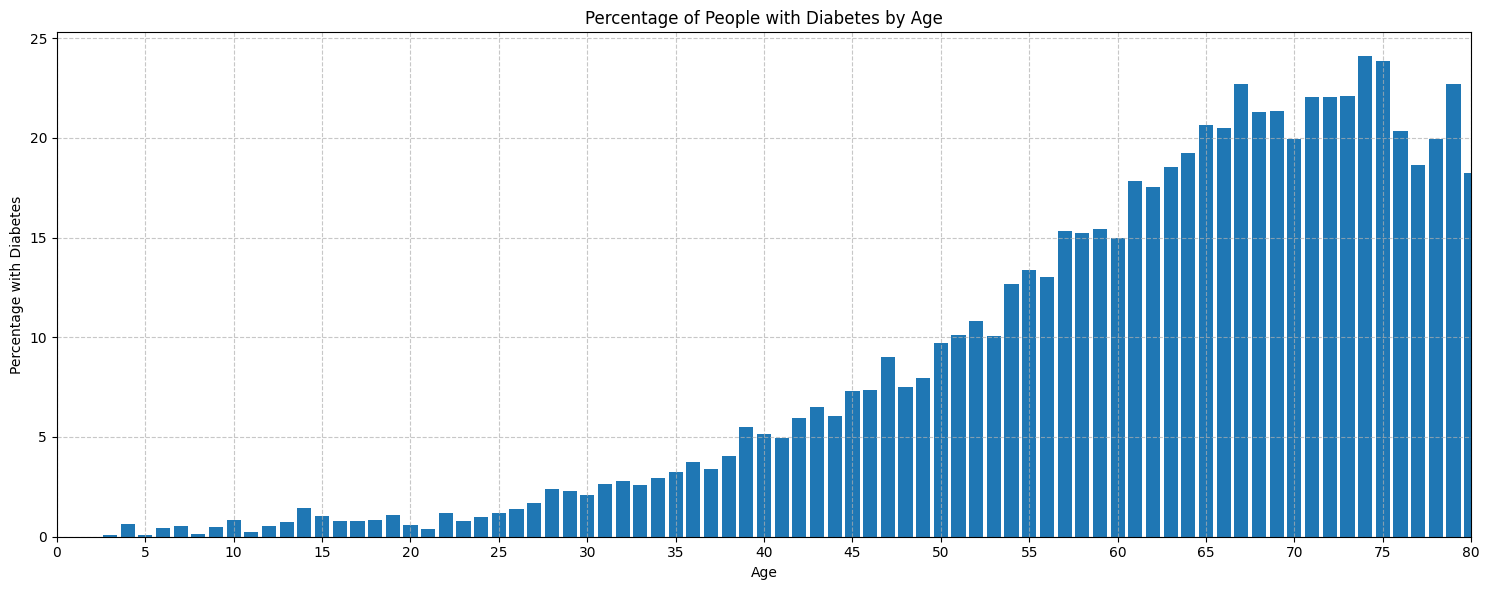

In [29]:
# Find and plot the amount of people with diabetes for each age

# Calculate the percentage of people with diabetes for each age
diabetes_by_age = df.groupby('Age')['Diabetes'].mean().reset_index()
diabetes_by_age['Percentage'] = diabetes_by_age['Diabetes'] * 100

plt.figure(figsize=(15, 6))

# Use a line plot instead of a bar plot
plt.bar(diabetes_by_age['Age'], diabetes_by_age['Percentage'], width=0.8)

plt.title('Percentage of People with Diabetes by Age')
plt.xlabel('Age')
plt.ylabel('Percentage with Diabetes')

# Set x-axis limits and ticks
plt.xlim(0, 80)
plt.xticks(range(0, 81, 5))  # Set ticks every 5 years

# Add grid lines for better readability
plt.grid(True, axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

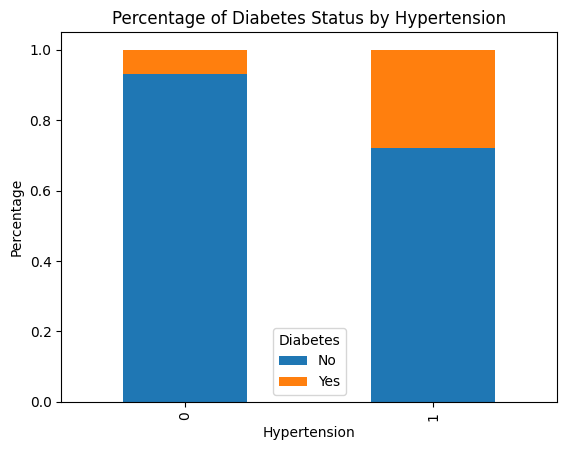

In [30]:
# Diabetes vs Hypertension Stacked percentage plot
plt.figure(figsize=(10, 6))
df_hyp = df.groupby('Hypertension')['Diabetes'].value_counts(normalize=True).unstack()
df_hyp.plot(kind='bar', stacked=True)
plt.title('Percentage of Diabetes Status by Hypertension')
plt.xlabel('Hypertension')
plt.ylabel('Percentage')
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.show()

<Figure size 1000x600 with 0 Axes>

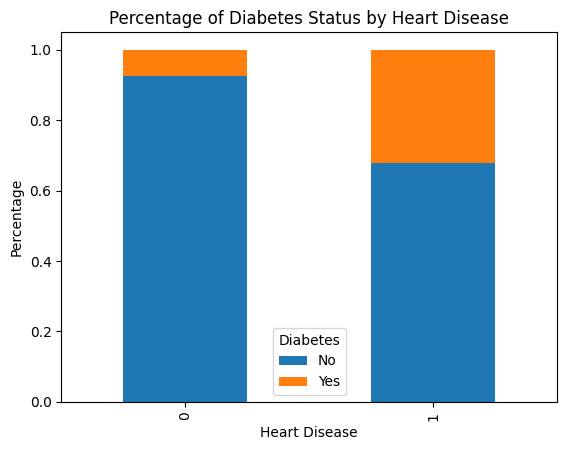

In [31]:
# Diabetes vs Heart Disease Stacked percentage plot
plt.figure(figsize=(10, 6))
df_hd = df.groupby('Heart Disease')['Diabetes'].value_counts(normalize=True).unstack()
df_hd.plot(kind='bar', stacked=True)
plt.title('Percentage of Diabetes Status by Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Percentage')
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.show()

# Create new features

In [32]:
# Combining Heart Disease and Hypertension into 'Combined Risk Factors'

df['Combined Risk Factors'] = df['Hypertension'] + df['Heart Disease']
df['Combined Risk Factors'].value_counts()

Combined Risk Factors
0    89475
1     9595
2      916
Name: count, dtype: int64

BMI info from CDC

https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html

Under 18.5: Underweight
18.5–24.9: Healthy weight
25.0–29.9: Overweight
30.0 and above: Obese
40 or over: Severely obese

Notice these are Adult Categories (20+) and we do have ages of less than 20 in the dataset

In [33]:
# Apply binning to 'BMI' using medical thresholds
# Create 'BMI_Category'

def bin_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 40:
        return 'Obese'
    else:
        return 'Severely Obese'

df['BMI_Category'] = df['BMI'].apply(bin_bmi)

There are multiple 'Blood Glucose' tests:
 - Random blood sugar test. A blood sample will be taken at a random time.
 - Fasting blood sugar test. A blood sample will be taken after you haven't eaten anything the night before.
 - Glucose tolerance test. For this test, you fast overnight. Then, the fasting blood sugar level is measured. 
 Then you drink a sugary liquid, and blood sugar levels are tested regularly for the next two hours.

 Let's apply binning using these thresholds and examine the results. We may consider changing the thresholds or using 
 a different binning method

 https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451

In [34]:
# Apply binning to 'Blood Glucose' using medical thresholds for fasting blood sugar
# Create 'Blood_Glucose_Category'

def bin_blood_glucose(x):
    """
    Categorize Blood Glucose levels into bins based on medical thresholds.
    Assumes fasting plasma glucose levels in mg/dL.
    
    :param x: Blood Glucose level (mg/dL)
    :return: Category as string
    """
    if x < 100:
        return 'Normal'
    elif 100 <= x < 126:
        return 'Prediabetes'
    else:
        return 'Diabetes'
    
df['Blood_Glucose_Category'] = df['Blood Glucose Level'].apply(bin_blood_glucose)

For an HbA1c test to classify as normal, or in the non-diabetic range, the value must be below 5.7 %. Anyone with an HbA1c value of 5.7 % to 6.4 % is considered to be prediabetic, while diabetes can be diagnosed with a HbA1c of 6.5% or higher.

https://my.clevelandclinic.org/health/diagnostics/9731-a1c

In [35]:
# Apply binning to 'HbA1c Level' using medical thresholds
# Create 'Blood_Glucose_Category'

def bin_hba1c(x):
    """
    Categorize HbA1c levels into bins based on medical thresholds.
    
    :param x: HbA1c level (percentage)
    :return: Category as string
    """
    if x < 5.7:
        return 'Normal'
    elif 5.7 <= x < 6.5:
        return 'Prediabetes'
    else:
        return 'Diabetes'
    
df['HbA1c_Category'] = df['HbA1c Level'].apply(bin_hba1c)

In [36]:
df_combined = df.groupby('Combined Risk Factors')['Diabetes'].value_counts(normalize=True)

<Figure size 1000x600 with 0 Axes>

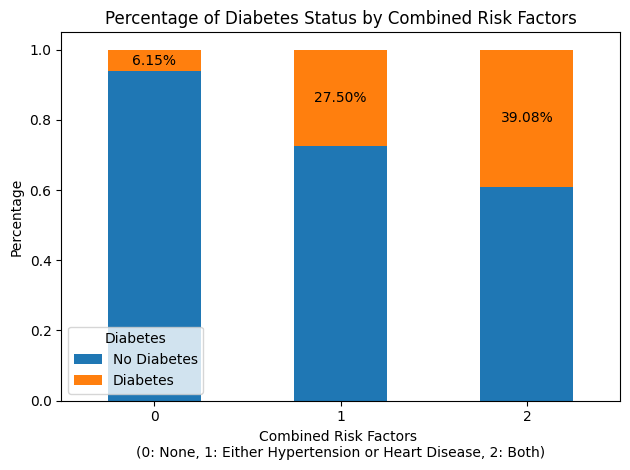

In [37]:
# Combined Risk Factors vs Diabetes Stacked percentage plot

df_combined = df.groupby('Combined Risk Factors')['Diabetes'].value_counts(normalize=True).unstack()
# Create stacked bar plot
plt.figure(figsize=(10, 6))
ax = df_combined.plot(kind='bar', stacked=True)

plt.title('Percentage of Diabetes Status by Combined Risk Factors')
plt.xlabel('Combined Risk Factors \n(0: None, 1: Either Hypertension or Heart Disease, 2: Both)')
plt.ylabel('Percentage')
plt.legend(title='Diabetes', labels=['No Diabetes', 'Diabetes'], loc='lower left')
plt.xticks(rotation=0)

# Add percentage labels only for the Diabetes (1) category
for container in ax.containers:
    if container.get_label() == '1': 
        ax.bar_label(container, fmt=lambda x: f'{x*100:.2f}%', label_type='center')
plt.tight_layout()

## Clustering 'Blood Glucose Level', 'HbA1c Level', 'BMI'

,Number of Clusters,Inertia
0,1,299958.000000
1,2,228697.822631
2,3,193180.495115
3,4,146301.212255
4,5,122708.556265
5,6,107661.970786
6,7,99699.519925
7,8,87408.254226
8,9,81886.005790
9,10,76981.305342


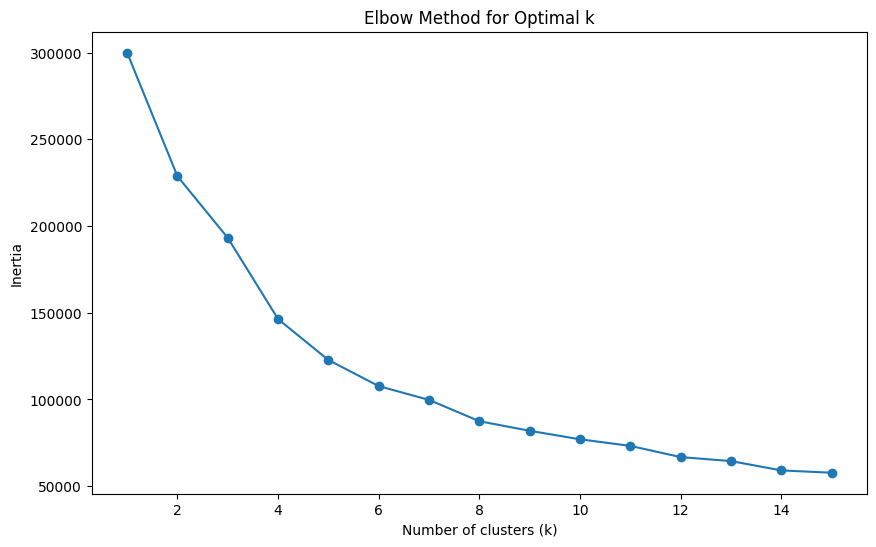

In [38]:
# First find the optimal number of clusters


features_to_cluster = ['HbA1c Level', 'Blood Glucose Level', 'BMI']
X = df[features_to_cluster]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
    
inertias = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Create and display the DataFrame
inertia_df = pd.DataFrame({
    'Number of Clusters': range(1, 16),
    'Inertia': inertias
})
display(inertia_df)    
    
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


Cluster Centers:
   HbA1c Level  Blood Glucose Level        BMI
0     6.208835           151.833743  25.256347
1     5.765103            88.399126  25.442181
2     6.877026           245.784991  32.167928
3     4.249577           141.722238  25.552972
4     5.698596           135.205369  39.649989


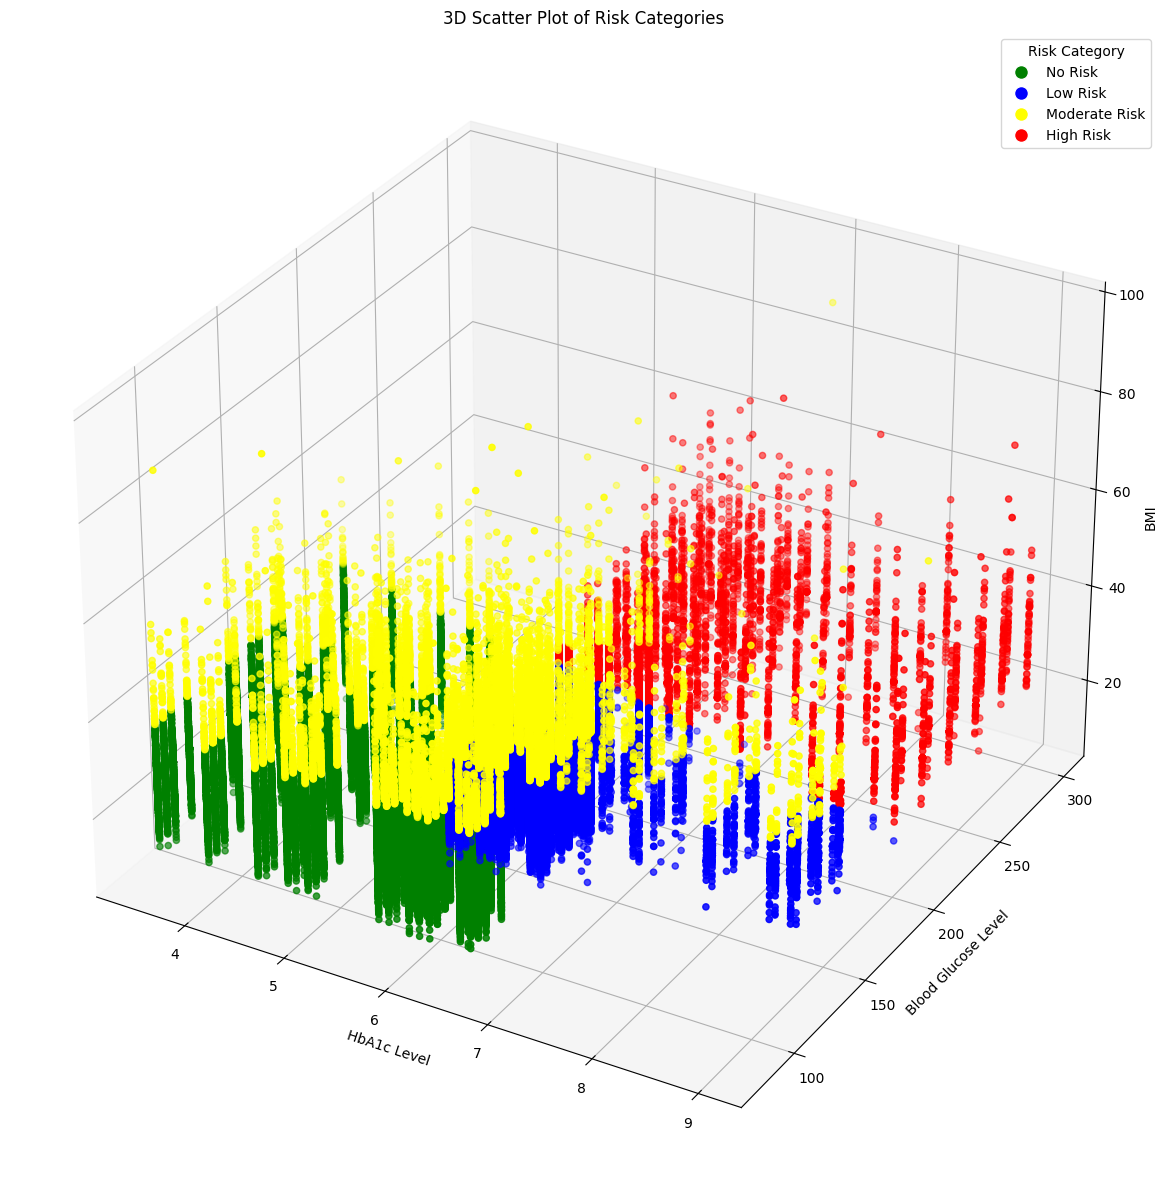

In [39]:

def cluster_features(df, features, n_clusters):
    """
    Cluster features using K-means.
    
    :param df: DataFrame containing the features
    :param features: List of feature names to cluster
    :param n_clusters: Number of clusters to create
    :return: DataFrame with original features and cluster labels
    """
    X = df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to the DataFrame
    df_clustered = df.copy()
    df_clustered['Cluster'] = cluster_labels
    
    # Print cluster centers
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    print("\nCluster Centers:")
    print(pd.DataFrame(cluster_centers, columns=features))
    
    return df_clustered


# Perform clustering with optimal number of clusters
df_clustered = cluster_features(df, features_to_cluster, 5)

# Define cluster descriptions
cluster_descriptions = {
    0: 'Low Risk',
    1: 'No Risk',
    2: 'High Risk',
    3: 'No Risk',
    4: 'Moderate Risk'
}

# Map cluster labels to descriptions
df_clustered['Risk_Category'] = df_clustered['Cluster'].map(cluster_descriptions)

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each risk category
risk_colors = {
    'High Risk': 'red',
    'Moderate Risk': 'yellow',
    'Low Risk': 'blue',
    'No Risk': 'green'
}

# Define the order for the legend
legend_order = ['No Risk', 'Low Risk', 'Moderate Risk', 'High Risk']

# Create a scatter plot for each unique risk category
for risk in set(cluster_descriptions.values()):
    cluster_data = df_clustered[df_clustered['Risk_Category'] == risk]
    scatter = ax.scatter(cluster_data['HbA1c Level'], 
                         cluster_data['Blood Glucose Level'], 
                         cluster_data['BMI'], 
                         c=risk_colors[risk],
                         label=risk)

ax.set_xlabel('HbA1c Level')
ax.set_ylabel('Blood Glucose Level')
ax.set_zlabel('BMI', rotation=90)

# Add a legend in the specified order
ax.legend(title='Risk Category', loc='upper right', handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=risk_colors[risk], markersize=10, label=risk)
    for risk in legend_order
])

plt.title('3D Scatter Plot of Risk Categories')
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()

In [40]:
df_clustered

,Year,Gender,Age,Location,Race : African American,Race : Asian,Race : Caucasian,Race : Hispanic,Race : Other,Hypertension,...,BMI,HbA1c Level,Blood Glucose Level,Diabetes,Combined Risk Factors,BMI_Category,Blood_Glucose_Category,HbA1c_Category,Cluster,Risk_Category
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,...,27.32,5.0,100,0,0,Overweight,Prediabetes,Normal,1,No Risk
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,...,19.95,5.0,90,0,0,Normal weight,Normal,Normal,1,No Risk
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,...,23.76,4.8,160,0,0,Normal weight,Diabetes,Normal,3,No Risk
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,...,27.32,4.0,159,0,0,Overweight,Diabetes,Normal,3,No Risk
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,...,23.75,6.5,90,0,0,Normal weight,Normal,Diabetes,1,No Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,Female,33.0,Wyoming,0,0,0,0,1,0,...,21.21,6.5,90,0,0,Normal weight,Normal,Diabetes,1,No Risk
99996,2016,Female,80.0,Wyoming,0,1,0,0,0,0,...,36.66,5.7,100,0,0,Obese,Prediabetes,Prediabetes,4,Moderate Risk
99997,2018,Male,46.0,Wyoming,0,1,0,0,0,0,...,36.12,6.2,158,0,0,Obese,Diabetes,Prediabetes,4,Moderate Risk
99998,2018,Female,51.0,Wyoming,1,0,0,0,0,0,...,29.29,6.0,155,0,0,Overweight,Diabetes,Prediabetes,0,Low Risk


Percentage of Positive Diabetes Diagnosis by Cluster:
Cluster 0 (Low Risk): 9.24%
Cluster 1 (No Risk): 0.00%
Cluster 2 (High Risk): 83.86%
Cluster 3 (No Risk): 0.00%
Cluster 4 (Moderate Risk): 14.06%


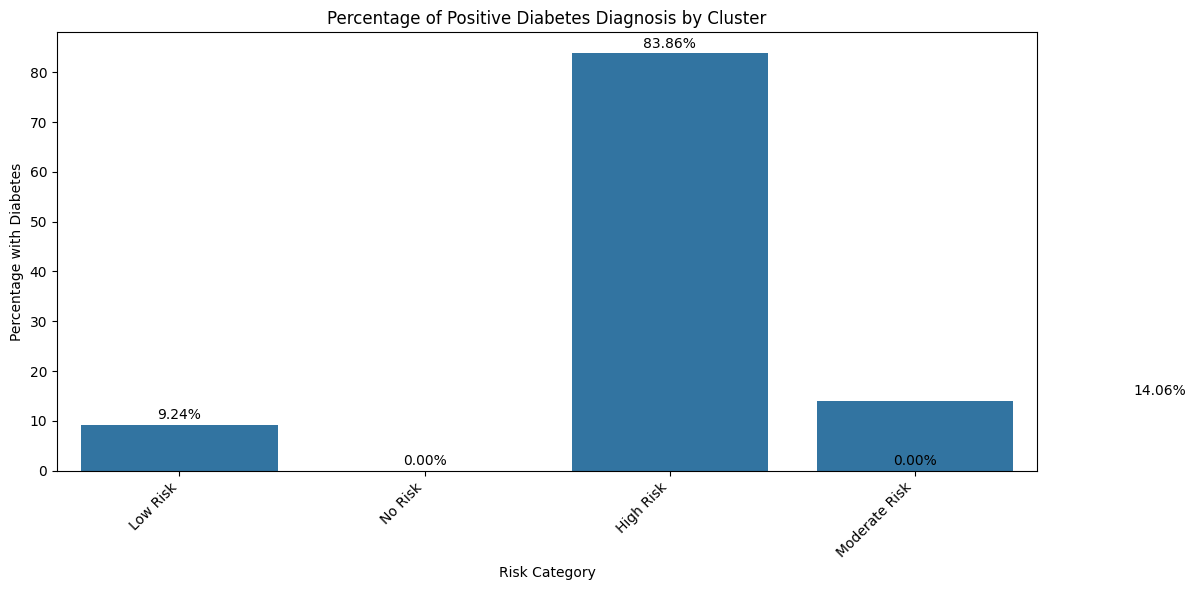

In [41]:
# Calculate the percentage of diabetes for each cluster
diabetes_by_cluster = df_clustered.groupby(['Cluster', 'Risk_Category'])['Diabetes'].mean().reset_index()
diabetes_by_cluster['Diabetes_Percentage'] = diabetes_by_cluster['Diabetes'] * 100

# Sort the results by cluster number
diabetes_by_cluster = diabetes_by_cluster.sort_values('Cluster')

# Display the results
print("Percentage of Positive Diabetes Diagnosis by Cluster:")
for _, row in diabetes_by_cluster.iterrows():
    print(f"Cluster {row['Cluster']} ({row['Risk_Category']}): {row['Diabetes_Percentage']:.2f}%")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Risk_Category', y='Diabetes_Percentage', data=diabetes_by_cluster, 
            order=diabetes_by_cluster.sort_values('Cluster')['Risk_Category'])

plt.title('Percentage of Positive Diabetes Diagnosis by Cluster')
plt.xlabel('Risk Category')
plt.ylabel('Percentage with Diabetes')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
for i, v in enumerate(diabetes_by_cluster['Diabetes_Percentage']):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99986 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     99986 non-null  int64  
 1   Gender                   99986 non-null  object 
 2   Age                      99986 non-null  float64
 3   Location                 99986 non-null  object 
 4   Race : African American  99986 non-null  int64  
 5   Race : Asian             99986 non-null  int64  
 6   Race : Caucasian         99986 non-null  int64  
 7   Race : Hispanic          99986 non-null  int64  
 8   Race : Other             99986 non-null  int64  
 9   Hypertension             99986 non-null  int64  
 10  Heart Disease            99986 non-null  int64  
 11  Smoking History          99986 non-null  object 
 12  BMI                      99986 non-null  float64
 13  HbA1c Level              99986 non-null  float64
 14  Blood Glucose Level      99

In [43]:
df['Smoking History'].value_counts()

Smoking History
No Info        35806
never          35091
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

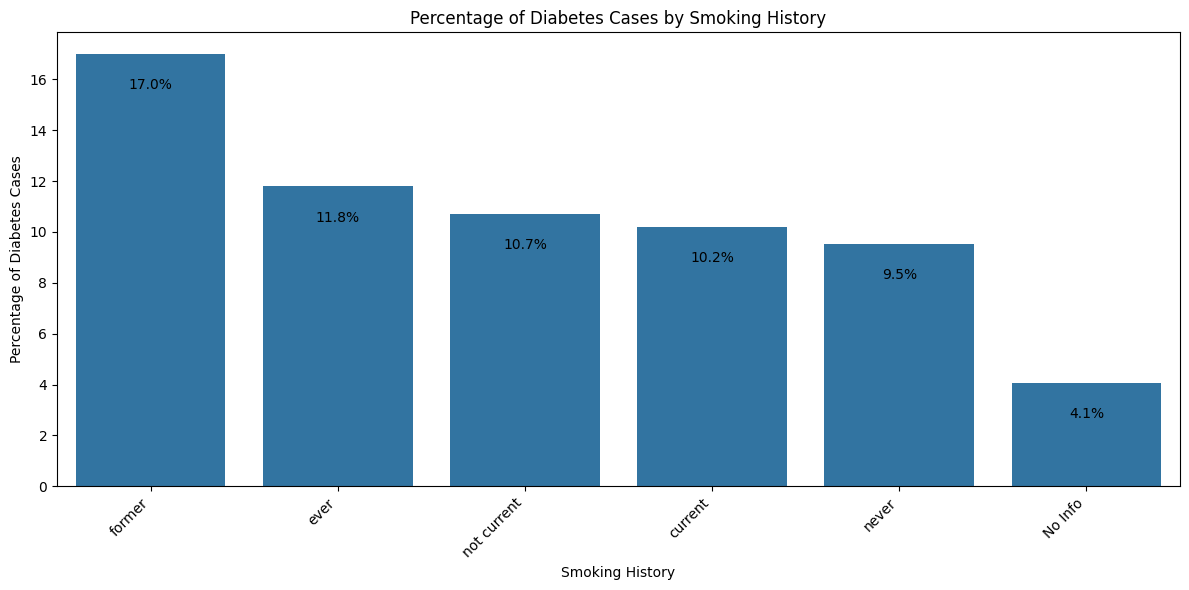

In [44]:
# Examine the Smoking History categories with target feature

# Calculate the percentage of diabetes cases for each Smoking History category
smoking_diabetes_pct = df.groupby('Smoking History')['Diabetes'].mean() * 100
smoking_diabetes_pct = smoking_diabetes_pct.sort_values(ascending=False).reset_index()
smoking_diabetes_pct.columns = ['Smoking History', 'Diabetes Percentage']

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=smoking_diabetes_pct, x='Smoking History', y='Diabetes Percentage')

# Customize the plot
plt.title('Percentage of Diabetes Cases by Smoking History')
plt.xlabel('Smoking History')
plt.ylabel('Percentage of Diabetes Cases')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
for i, v in enumerate(smoking_diabetes_pct['Diabetes Percentage']):
    plt.text(i, v - 1.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Exploring Groupbys with Target Feature

In [45]:
# Try grouping the smoking categories

df['Smoking History Grouped'] = df['Smoking History'].replace({'former': 'has smoked', 'ever': 'has smoked', 'not current': 'has smoked'})

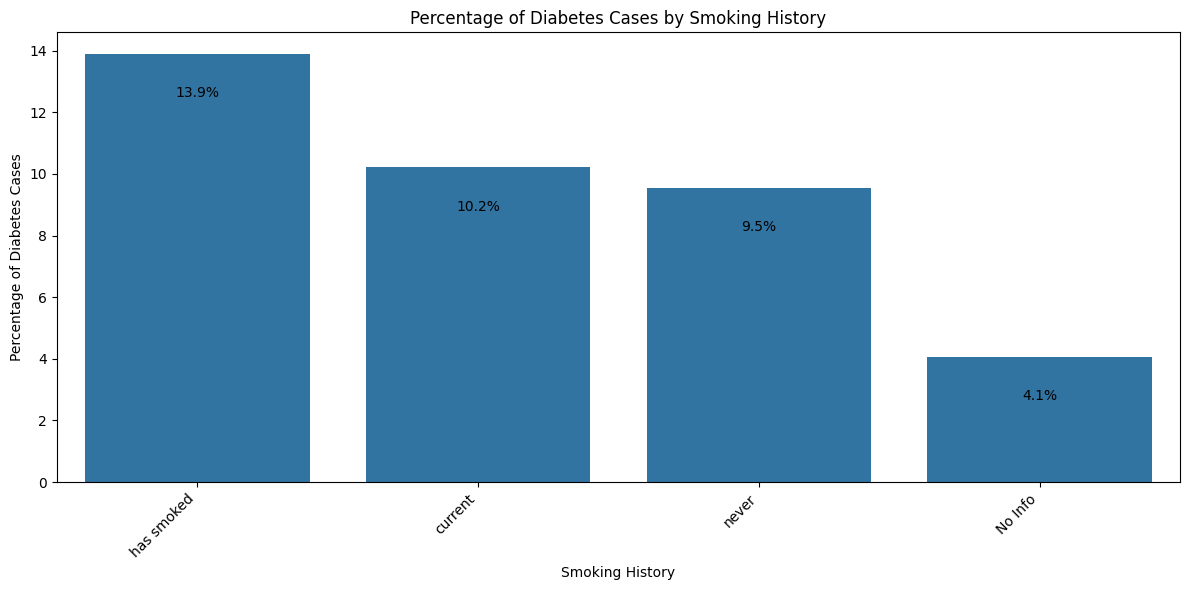

In [46]:
# Examine the Smoking History categories with target feature

# Calculate the percentage of diabetes cases for each Smoking History category
smoking_diabetes_pct = df.groupby('Smoking History Grouped')['Diabetes'].mean() * 100
smoking_diabetes_pct = smoking_diabetes_pct.sort_values(ascending=False).reset_index()
smoking_diabetes_pct.columns = ['Smoking History', 'Diabetes Percentage']

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=smoking_diabetes_pct, x='Smoking History', y='Diabetes Percentage')

# Customize the plot
plt.title('Percentage of Diabetes Cases by Smoking History')
plt.xlabel('Smoking History')
plt.ylabel('Percentage of Diabetes Cases')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
for i, v in enumerate(smoking_diabetes_pct['Diabetes Percentage']):
    plt.text(i, v - 1.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\16148\AppData\Local\Temp\ipykernel_28416\3727841981.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bin_diabetes = df.groupby('Age_Bin')['Diabetes'].agg(['sum', 'count']).reset_index()


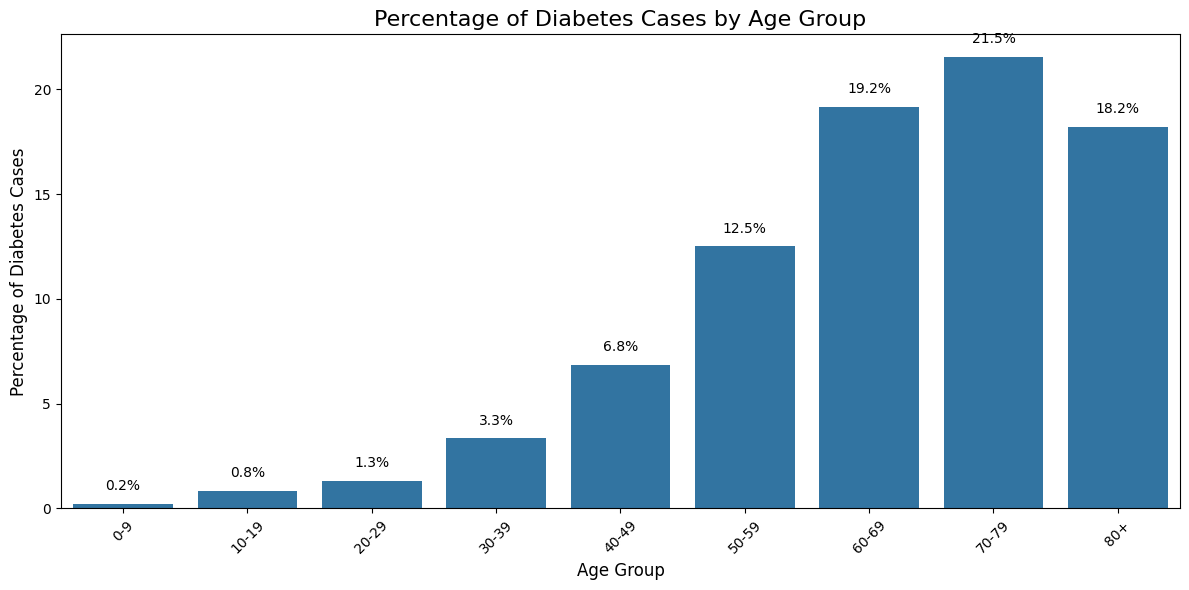

In [47]:
# Groupby Age (Binned) with Target == 1

# Create age bins
bins = list(range(0, 81, 10)) + [81] 
labels = [f'{i}-{i+9}' for i in range(0, 71, 10)] + ['80+']
df['Age_Bin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate the percentage of diabetes cases in each age group
age_bin_diabetes = df.groupby('Age_Bin')['Diabetes'].agg(['sum', 'count']).reset_index()
age_bin_diabetes['Diabetes_Percentage'] = (age_bin_diabetes['sum'] / age_bin_diabetes['count']) * 100

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=age_bin_diabetes, x='Age_Bin', y='Diabetes_Percentage')

# Customize the plot
plt.title('Percentage of Diabetes Cases by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Percentage of Diabetes Cases', fontsize=12)
plt.xticks(rotation=45)

# Add percentage labels on top of each bar
for i, v in enumerate(age_bin_diabetes['Diabetes_Percentage']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

df = df.drop(columns='Age_Bin')

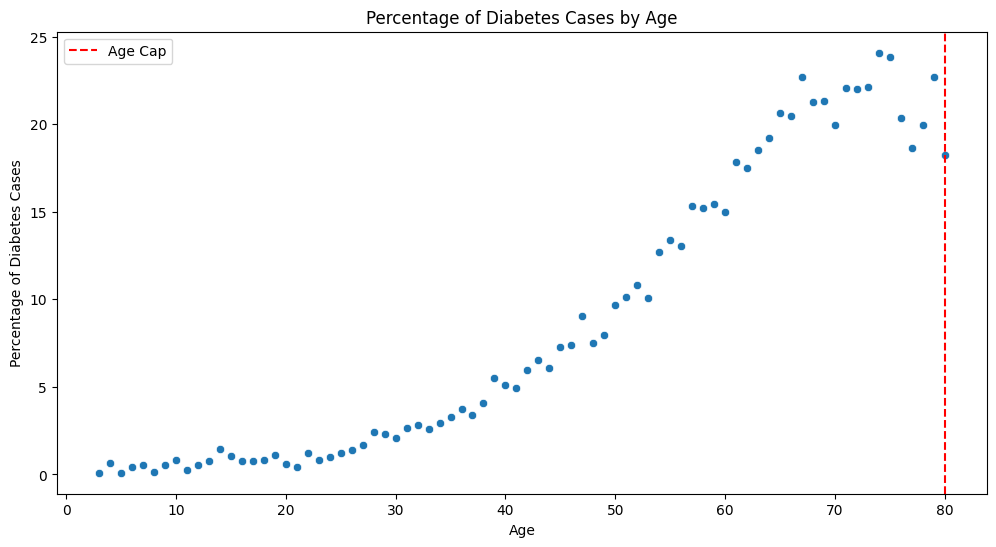

In [48]:
# Calculate total count and diabetes count for each age
age_total = df.groupby('Age')['Diabetes'].count().reset_index(name='Total_Count')
age_diabetes = df[df['Diabetes'] == 1].groupby('Age')['Diabetes'].count().reset_index(name='Diabetes_Count')

# Merge the two dataframes
age_merged = pd.merge(age_total, age_diabetes, on='Age', how='left')

# Calculate the percentage
age_merged['Diabetes_Percentage'] = (age_merged['Diabetes_Count'] / age_merged['Total_Count']) * 100

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=age_merged, x='Age', y='Diabetes_Percentage')
plt.title('Percentage of Diabetes Cases by Age')
plt.xlabel('Age')
plt.ylabel('Percentage of Diabetes Cases')
plt.axvline(x=80, color='r', linestyle='--', label='Age Cap')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

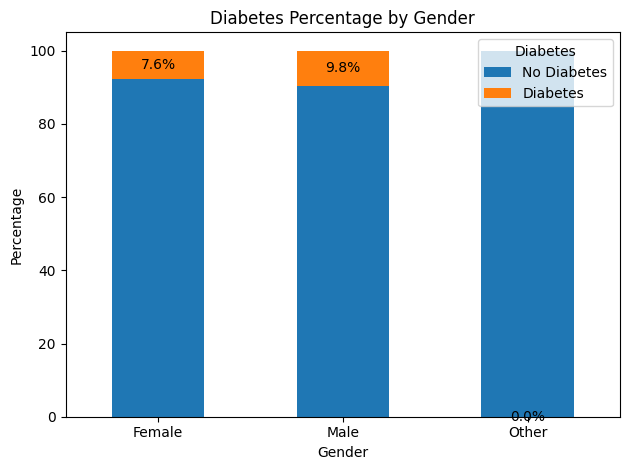

In [49]:
# Gender with Percent Diabetes stacked bar plot

gender_diabetes = df.groupby(['Gender', 'Diabetes']).size().unstack(fill_value=0)

# Calculate percentages
gender_diabetes_pct = gender_diabetes.div(gender_diabetes.sum(axis=1), axis=0) * 100

# Create stacked bar plot
plt.figure(figsize=(10, 6))
ax = gender_diabetes_pct.plot(kind='bar', stacked=True)

plt.title('Diabetes Percentage by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.legend(title='Diabetes', labels=['No Diabetes', 'Diabetes'])
plt.xticks(rotation=0)

# Add percentage labels only for the Diabetes (1) category
for container in ax.containers:
    if container.get_label() == '1':
        ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

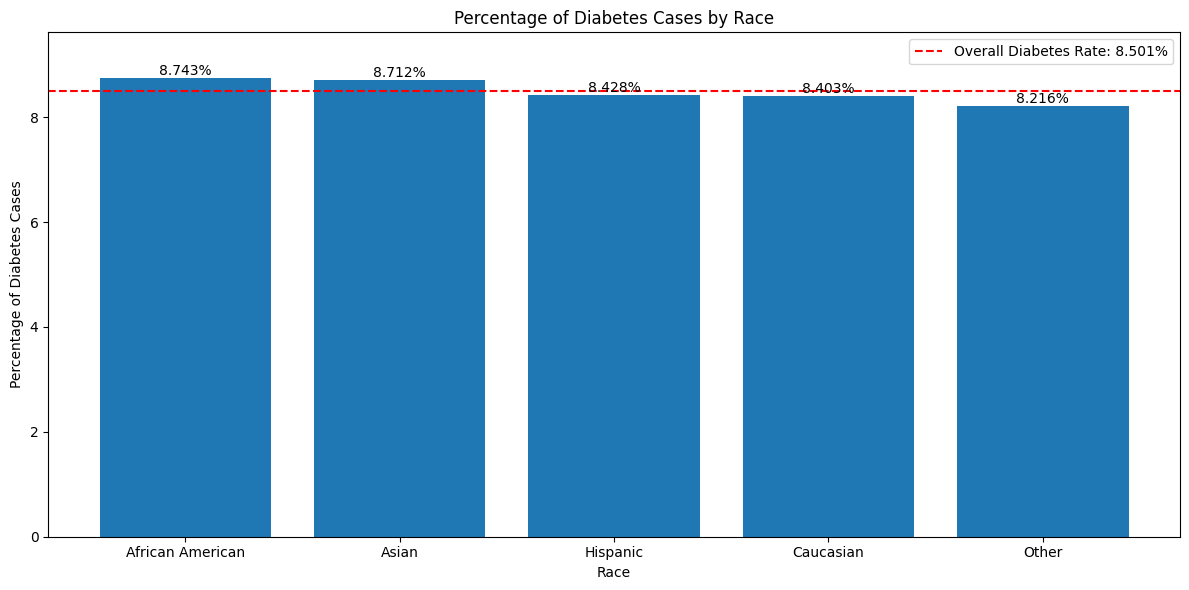

In [50]:
# Plot Diabetes cases by Race

race_columns = ['Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other']

# Calculate the percentage of diabetes cases for each race
race_percentages = []
for race in race_columns:
    total = df[race].sum()
    diabetes_cases = df[df['Diabetes'] == 1][race].sum()
    percentage = (diabetes_cases / total * 100) if total > 0 else 0
    race_percentages.append(percentage)

# Create a new DataFrame with the results
results = pd.DataFrame({
    'Race': [col.replace('Race : ', '') for col in race_columns],
    'Diabetes Percentage': race_percentages
})

# Sort the results by percentage in descending order
results = results.sort_values('Diabetes Percentage', ascending=False)

# Calculate the overall diabetes rate
total_population = 91486 + 8500
overall_diabetes_rate = (8500 / total_population) * 100

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(results['Race'], results['Diabetes Percentage'])
plt.title('Percentage of Diabetes Cases by Race')
plt.xlabel('Race')
plt.ylabel('Percentage of Diabetes Cases')
plt.ylim(0, max(results['Diabetes Percentage'].max(), overall_diabetes_rate) * 1.1)  # Adjust y-axis limit

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}%',
             ha='center', va='bottom')

# Add horizontal line for overall diabetes rate
plt.axhline(y=overall_diabetes_rate, color='r', linestyle='--', label=f'Overall Diabetes Rate: {overall_diabetes_rate:.3f}%')

plt.legend()
plt.tight_layout()
plt.show()

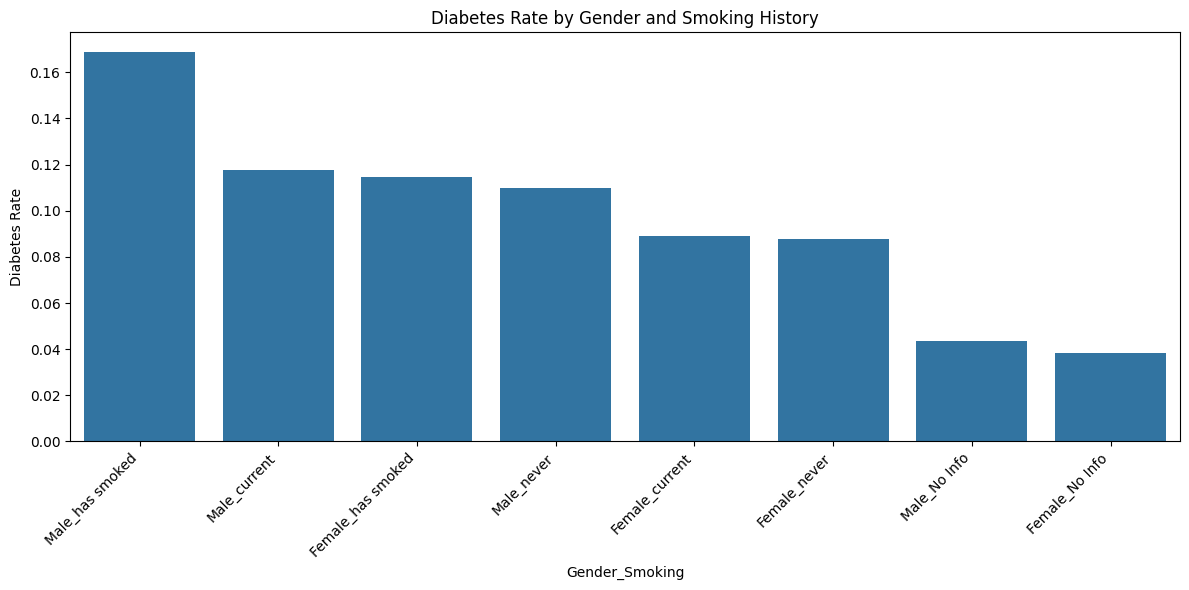


Diabetes Rate by Gender_Smoking:
Gender_Smoking
Male_has smoked      16.89%
Male_current         11.75%
Female_has smoked    11.48%
Male_never           11.00%
Female_current        8.92%
Female_never          8.75%
Male_No Info          4.35%
Female_No Info        3.83%
Name: Diabetes, dtype: object


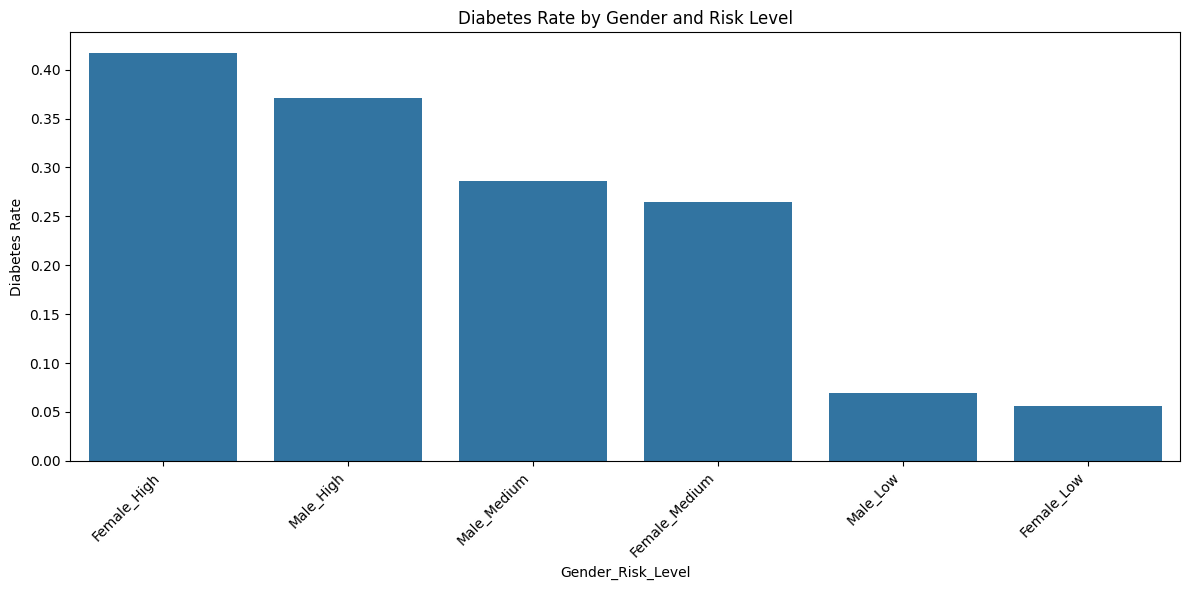


Diabetes Rate by Gender_Risk_Level:
Gender_Risk_Level
Female_High      41.73%
Male_High        37.09%
Male_Medium      28.62%
Female_Medium    26.46%
Male_Low          6.95%
Female_Low        5.61%
Name: Diabetes, dtype: object


In [51]:
# Gender and Smoking History grouped vs Diabetes

def create_gender_smoking_groups(df):
    df['Gender_Smoking'] = df['Gender'] + '_' + df['Smoking History Grouped']
    return df

def create_gender_risk_groups(df):
    # Custom mapping for risk levels
    risk_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
    df['Risk_Level'] = df['Combined Risk Factors'].map(risk_mapping)
    df['Gender_Risk_Level'] = df['Gender'] + '_' + df['Risk_Level']
    return df

# Apply the feature engineering
df = create_gender_smoking_groups(df)
df = create_gender_risk_groups(df)


def plot_feature_target_interaction(df, feature, target='Diabetes', title=None):

    df_filtered = df[~df['Gender'].isin(['Other'])]
    plt.figure(figsize=(12, 6))
    
    # Calculate the percentage of positive cases for each category
    diabetes_rate = df_filtered.groupby(feature)[target].mean().sort_values(ascending=False)
    
    # Plot the bar chart
    sns.barplot(x=diabetes_rate.index, y=diabetes_rate.values)
    
    plt.title(title or f'Diabetes Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Diabetes Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print the exact percentages
    print(f"\nDiabetes Rate by {feature}:")
    print(diabetes_rate.apply(lambda x: f"{x:.2%}"))

# Plot the interactions
plot_feature_target_interaction(df, 'Gender_Smoking', title='Diabetes Rate by Gender and Smoking History')
plot_feature_target_interaction(df, 'Gender_Risk_Level', title='Diabetes Rate by Gender and Risk Level')

# Drop the temp columns

df = df.drop(columns=['Gender_Risk_Level','Gender_Smoking'])

# Examine the dataset before saving for use in model evaluation notebook

In [52]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'Combined Risk Factors', 'BMI_Category', 'Blood_Glucose_Category',
       'HbA1c_Category', 'Smoking History Grouped', 'Risk_Level'],
      dtype='object')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99986 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     99986 non-null  int64  
 1   Gender                   99986 non-null  object 
 2   Age                      99986 non-null  float64
 3   Location                 99986 non-null  object 
 4   Race : African American  99986 non-null  int64  
 5   Race : Asian             99986 non-null  int64  
 6   Race : Caucasian         99986 non-null  int64  
 7   Race : Hispanic          99986 non-null  int64  
 8   Race : Other             99986 non-null  int64  
 9   Hypertension             99986 non-null  int64  
 10  Heart Disease            99986 non-null  int64  
 11  Smoking History          99986 non-null  object 
 12  BMI                      99986 non-null  float64
 13  HbA1c Level              99986 non-null  float64
 14  Blood Glucose Level      99

In [54]:
# Save the Cleaned dataframe
df = df.drop(columns='Risk_Level')
df.to_csv('cleaned_patient_data.csv', index=False)